# "Title"
> "Old SKool Image Classification"

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [CV, image classification, feature engineering, pyTorch, CIFAR10]
- image: images/blog1.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Old School CV: Image Texture 
----

## Introduction

The objective of the current notebook is to give a glimpse of some of the methods for feature extraction that were prevelent before the advent of Deep Neural Networks in the Computer Vision domain.

In the current Notebook we shall see how to do the same using the Python language with CIFAR10 dataset. The goal is to extract several features from the provided images and finally perform Image Classification using a Multi Layer Perceptron.

## Texture Analysis

On the preface of the book _Image Processing: Dealing with Textures_ [[1]](#1), the authors provided a very captivating definition of Texture: __Texture is what makes life beautiful; texture is what makes life interesting and texture is what makes life possible. Texture is what makes Mozart’s music beautiful, the masterpieces of the art of the Renaissance classical and the facades of Barcelona’s buildings attractive."__.(Not so helpful eh!)    

So, what is Texture? Technically, its the 'variation of Data on a smaller scale than the scale of interest'.

Classical Visual Computing comprises of two main branches when it comes to analyzing Texture of an Image [[1]](#1):
1. Structural    
    - Local Binary Pattern
    - Gabor Wavelets
    - Fourier Co-efficients
2. Statistical    
    - Co-Occurance Matrix
    - Orientation Histogram


## Workflow

- We shall start by downloading the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

- Next, we manually craft the features to obtain Texture Metrics.

- After creating functions to obtain textual features from an image, we create a loop to extract the same from all the images in Training and Test dataset.

- Next, we save the Training and Test set extracted features as serialized file. 

- Then we shall use the created features as co-variates against the label for each image and train a Softmax classifier on the Training Set. 

- Eventually, we evaluate the classifier on the Test set. 

In [ ]:
%matplotlib inline

from torchvision import datasets
import PIL
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor

import torch
from torch import nn 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import tqdm
from tqdm import notebook

from pathlib import Path
import pickle
import time

### Data Loading

In [ ]:
trainDset =  datasets.CIFAR10(root="./cifar10/", train=True, download=True)
testDset = datasets.CIFAR10(root = "./cifar10/", train=False, download=True)


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [ ]:
# Looking at a single image

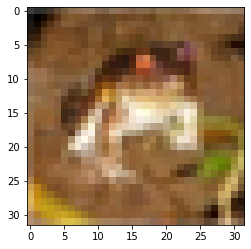

In [ ]:
#collapse
img = trainDset[0][0] # PIL Image
img_grey  = img.convert('L') # convert to Grey-scale
img_arr = np.array(img_grey) # convert to numpy array
plt.imshow(img)

## Local Binary Patterns(LBP)

LBP is helpful in extracting "local" structure of the image. It does so by encoding the local neighbourhood after they have been maximally simplified, i.e. binarized. In case, we want to perform LBP on a coloured image, we need to do so individually on each channel(Red/Blue/Green).

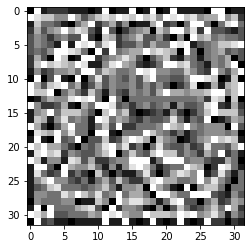

In [ ]:
#collapse
feat_lbp = local_binary_pattern(img_arr, 8,1,'uniform')
feat_lbp = np.uint8( (feat_lbp/feat_lbp.max())*255) # converting to unit 8
lbp_img = PIL.Image.fromarray(feat_lbp) # Convert from array

plt.imshow(lbp_img, cmap = 'gray')

In [ ]:
# Energy, Entropy

def get_lbp(img):
  """Function to implement Local Binary Pattern"""
  lbp_hist, _ = np.histogram(img, 8)
  lbp_hist = np.array(lbp_hist, dtype = float)
  lbp_prob = np.divide(lbp_hist, np.sum(lbp_hist))
  lbp_prob = np.where(np.isclose(0, lbp_prob), 0.0000000001, lbp_prob) # to avoid log(0)
  lbp_energy = np.sum(lbp_prob**2)
  lbp_entropy = -np.sum(np.multiply(lbp_prob, np.log2(lbp_prob)))
  return lbp_energy, lbp_entropy

## Co Occurence Matrix

Intiutively, if we were to extract information of a pixel in an image and also record its neighbouring pixels and their intensities, we will be able to capture both spatial and relative information. This is where Co-Occurance matrix are useful. They extract the representation of joint probability of chosen set of pixels having certain values. 

Once we have the co-occurance matrix, we can start calculating the feature matrics such as:
- $\textbf{Energy} = \sum_{m=0}^{G-1}\sum_{n=0}^{G-1}p^2\left(m,n\right)$

- $\textbf{Entropy} = \sum_{m=0}^{G-1}\sum_{n=0}^{G-1}p\left(m,n\right)\cdot log \left(p\left(m,n\right)\right)$

- $\textbf{Contrast} = \frac{1}{(G-1)^2}\sum_{m=0}^{G-1}\sum_{n=0}^{G-1}(m-n)^2\cdot p(m,n)$
- $\textbf{Homogeneity} = \sum_{m=0}^{G-1}\sum_{n=0}^{G-1} \frac{p(m,n)}{1+|m-n|}$

Where, $m,n$ are the neighbouring pixels and $G$ is the total number of grey levels we use. $G=256$ for an 8-bit gray-scale image

In [ ]:
def creat_cooccur(img_arr, *args, **kwargs):
  """Implements extraction of features from Co-Occurance Matrix"""
  gCoMat = greycomatrix(img_arr, [2], [0], 256, symmetric=True, normed=True)
  contrast = greycoprops(gCoMat, prop='contrast')
  dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
  homogeneity = greycoprops(gCoMat, prop='homogeneity')
  energy = greycoprops(gCoMat, prop='energy')
  correlation = greycoprops(gCoMat, prop = 'correlation')
  return contrast[0][0], dissimilarity[0][0], homogeneity[0][0], energy[0][0], correlation[0][0]

In [ ]:
#collapse
gCoMat = greycomatrix(img_arr, [2], [0], 256, symmetric=True, normed=True)
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop = 'correlation')
print(energy[0][0])

## [Gabor Filter](https://en.wikipedia.org/wiki/Gabor_filter#Applications_of_2-D_Gabor_filters_in_image_processing)



In [ ]:
gf_real, gf_img = gabor(img_arr, frequency=0.6)
gf  =(gf_real**2 + gf_img**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gf_real,cmap='gray')
ax[1].imshow(gf_img,cmap='gray')
ax[2].imshow(gf,cmap='gray')

In [ ]:
def get_gabor(img, N, *args, **kwargs):
  """Gabor Feature extraction"""
  gf_real, gf_img = gabor(img_arr, frequency=0.6)
  gf  =(gf_real**2 + gf_img**2)//2
  gabor_hist, _ = np.histogram(gf, N)
  gabor_hist = np.array(gabor_hist, dtype = float)
  gabor_prob = np.divide(gabor_hist, np.sum(gabor_hist))
  # To discard pixels resulting in 0 probability
  gabor_prob = np.where(np.isclose(0, gabor_prob), 0.0000000001, gabor_prob)
  gabor_energy = np.sum(gabor_prob**2)
  gabor_entropy = np.sum(np.multiply(gabor_prob, np.log2(gabor_prob)))
  return gabor_energy, gabor_entropy

## Feature Extraction

In [ ]:
# Generate Training Data
# Extract features from all images

label = []

featLength = 2+5+2 # LBP, Co-occurance, Gabor
trainFeats = np.zeros((len(trainDset), featLength))
testFeats = np.zeros((len(testDset), featLength))

In [ ]:
label = [trainDset[tr][1] for tr in tqdm.tqdm_notebook(range(len(trainFeats)))]

trainLabel = np.array(label)

In [ ]:
for tr in tqdm.tqdm_notebook(range(len(trainFeats))):
  img = trainDset[tr][0]
  img_grey = img.convert('L')
  img_arr = np.array(img_grey.getdata()).reshape(img.size[1], img.size[0])
  # LBP 
  feat_lbp = local_binary_pattern(img_arr, 5,2,'uniform').reshape(img.size[0]*img.size[1])
  feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255) # converting to unit 8
  lbp_energy, lbp_entropy = get_lbp(feat_lbp)
  # Co-Occurance
  gCoMat = greycomatrix(img_arr, [2], [0], 256, True,True)
  featglcm  = np.array(creat_cooccur(img_arr))
  # Gabor
  gabor_energy, gabor_entropy = get_gabor(img_arr, 8)

  # Concat features
  concat_feat = np.concatenate(([lbp_energy, lbp_entropy], featglcm, [gabor_energy, gabor_entropy]), axis=0)
  trainFeats[tr,:] = concat_feat
  label.append(trainDset[tr][1])
trainLabel = np.array(label)

In [ ]:
label = []

for ts in tqdm.tqdm_notebook(range(len(testDset))):
  img = testDset[ts][0]
  img_grey = img.convert('L')
  img_arr = np.array(img_grey.getdata()).reshape(img.size[1], img.size[0])
  # LBP 
  feat_lbp = local_binary_pattern(img_arr, 5,2,'uniform').reshape(img.size[0]*img.size[1])
  lbp_energy, lbp_entropy = get_lbp(feat_lbp)
  # Co-Occurance
  gCoMat = greycomatrix(img_arr, [2], [0], 256, True,True)
  featglcm  = np.array(creat_cooccur(img_arr))
  # Gabor
  gabor_energy, gabor_entropy = get_gabor(img_arr, 8)

  # Concat features
  concat_feat = np.concatenate(([lbp_energy, lbp_entropy], featglcm, [gabor_energy, gabor_entropy]), axis=0)

  testFeats[ts,:] = concat_feat
  label.append(testDset[ts][1]) 

testLabel = np.array(label)

### Normalize Features

In [ ]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(50000,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(50000,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

### Save Data

In [ ]:
with open("TrainFeats.pckl", "wb") as f:
  pickle.dump(trainFeatsNorm, f)
with open("TrainLabel.pckl", "wb") as f:
  pickle.dump(trainLabel, f)

with open("TestFeats.pckl", "wb") as f:
  pickle.dump(testFeatsNorm, f)
with open("TestLabel.pckl", "wb") as f:
  pickle.dump(testLabel, f)
print("files Saved!")

## Classification with SoftMax Regression

### Data Preparation


In [ ]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 100
batch_size = 64

# Architecture
num_features = 9
num_classes = 10

##########################
### CIFAR10 DATASET
##########################
## Converting Numpy array to Torch-Tensor

trainLabels = torch.from_numpy(trainLabel)
trainDataset = TensorDataset(torch.from_numpy(trainFeats),trainLabels)

testLabels = torch.from_numpy(testLabel)
testDataset = TensorDataset(torch.from_numpy(testFeats), testLabels)

## Creating DataLoader

train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(testDataset,batch_size=batch_size,shuffle=False)

### Define Model

In [ ]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        # self.linear.weight.detach().zero_()
        # self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(DEVICE)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Define Training Route

In [ ]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.float().view(-1, 9).to(DEVICE)
        targets = targets.to(DEVICE)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.float().view(-1, 9).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(trainDataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(trainDataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

### Model Performance

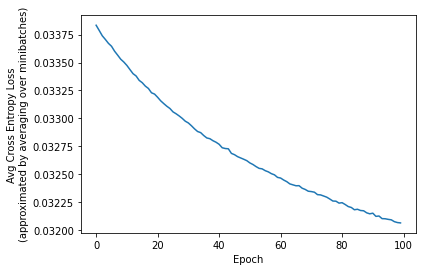

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print(f'Train accuracy: {(compute_accuracy(model, train_loader)): .2f}%')
print(f'Train accuracy: {(compute_accuracy(model, test_loader)): .2f}%')

Train accuracy:  24.92%
Train accuracy:  25.29%


## Comments

- This was a demonstration of how we can use manually crafted features in Image Classification tasks.
- The model can be improved in several ways:
    - Tweaking the parameters to modify features generated for **_LBP, Co-Occurance Matrix and Gabor Filter_**
    - Extending the parameters for Red,Blue and Green channels.
    - Modifying the Learning rate, Epochs.
    - Trying a different Algorithm such as Multi Layer Perceptron.
- The results aren't great but offer a glimpse of manually creating features from images.

## References
<a id="1">[1]</a> 
Maria MP, and Sevilla PG. _Image processing: dealing with texture_. John Wiley & Sons, 2006.